<a href="https://colab.research.google.com/github/lhb00/basic_pytorch_for_deeplearning/blob/main/basic_pytorch_for_deeplearning_theme_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Theme 9. 성능 개선
####(1) 과적합

#####1. 데이터 증식

In [ ]:
# 딥러닝은 많은 데이터를 요구 => 추가 데이터를 확보할 수 있으면 성능 향상에 도움됨.
# 당연히 직접 추가 데이터 모으는건 비용, 시간 때문에 쉽지는 않다. => 데이터 증식 기법을 통해 임의로 새로운 데이터를 만들어 학습 데이터에 추가
# 데이터 증식은 통계적 기법, 단순 변형, 생성 모델 이용 등이 있으며 목적과 상황에 따라 다양한 방법 사용, 이번 예시에서는 torchvision.transforms에서 제공하는 이미지 데이터 증식 사용.
import torchvision.transforms as tr
import PIL

transf = tr.Compose([tr.ToPILImage(), tr.RandomCrop(60), # 앞에서 나왔던 것처럼 Dataset을 정의하기 전 tranf 정의. 많은 기능들이 타입이 PIL일 경우에만 작동하므로 사용전에 데이터 타입 확인 필수!
# RandomCrop(60)은 크기가 60X60으로 이미지 일부를 무작위로 잘라서 같은 이미지라도 매번 다른 입력 이미지로 모델에 들어갈 수 있게 함. 
# ColorJitter는 이미지의 밝기, 대비, 색조 변형 => 새로운 이미지로 만듦.
# RandomHorizontalFlip은 이미지를 뒤집는 것. 그 외 회전, 흑백 이미지 등 다양한 기법 존재
tr.ColorJitter(brightness=0.1,contrast=0.1, saturation=0.1,
               hue=0.1), tr.RandomHorizontalFlip(), tr.ToTensor()])

#####2. 조기 종료

In [ ]:
# 라이브러리 불러오기
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# 학습, 검증, 평가 데이터 생성
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.CIFAR10(root = '/content/drive/MyDrive/deeplearning/data', train = True,
                                       download = True, transform = transform)
trainset, valset = torch.utils.data.random_split(dataset, [30000, 20000]) # torch.utils.data.random_split을 통해 50000개의 dataset을 학습 데이터 30000개, 검증 데이터 20000개로 나눔.
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/deeplearning/data', train = False,
                                       download=True, transform = transform) # 평가 데이터는 train=False로 생성
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# GPU 연산 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
# 모델 정의하기 : ResNet 이용
import torchvision.models as models
resnet = models.resnet18()
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(nn.Dropout2d(0.5), nn.Linear(num_ftrs, 10))
resnet = resnet.to(device)

In [ ]:
# 손실 함수 및 최적화 기법
PATH = '/content/drive/MyDrive/deeplearning/models/cifar_resnet_early.pth' # 저장 모델명 정의
criterion = nn.CrossEntropyLoss() # 크로스 엔트로피 함수
optimizer = optim.Adam(resnet.parameters(), lr=1e-3) # Adam 이용

In [ ]:
# 겅증 데이터에 대한 손실 함수값 연산 함수 정의
def validation_loss(dataloader):
  n = len(dataloader)
  running_loss = 0.0
  with torch.no_grad(): # 평가만 하므로 requires_grad 비활성화
    resnet.eval() # 평가 시 정규화 기법들이 작동하지 않도록 eval 모드로 설정
    for data in dataloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = resnet(images)
      loss = criterion(outputs, labels)
      running_loss+=loss.item()
  resnet.train() # 모델을 train 모드로 변경
  return running_loss / n

In [ ]:
# 학습하기
train_loss_list = [] # 손실 함수 그래프를 그리기 위해 학습/검증 데이터에 대한 손실 함수값을 각각 담을 수 있는 빈 리스트 생성
val_loss_list = []
n = len(trainloader) # 매 에포크 마다 평균 손실 함수 값을 구하기 위해 n 설정
early_stopping_loss = 1 # 가장 낮은 검증 손실 함수값에 해당하는 모델을 저장하기 위해 손실 함수값 초기 기준을 1로 한다.
for epoch in range(51):
  running_loss = 0.0
  for data in trainloader: # 배치 데이터를 받아 학습 진행
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = resnet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  train_loss = running_loss / n # 배치 학습이 한 번 완료될 때마다 평균 손실 함수값 저장
  train_loss_list.append(train_loss)
  val_loss = validation_loss(valloader) # 검증 데이터에 대한 손실 함수값 저장
  val_loss_list.append(val_loss)
  print('[%d] train loss: %.3f, validation loss: %.3f' %(epoch + 1, train_loss, val_loss)) # 현재 에포크의 평가, 검증 손실 함수값 출력
  if val_loss < early_stopping_loss: # 만약 현재 검증 손실 함수값 < 기준 => 모델 저장 & 현재의 에포크, 평가, 검증 손실 함수값 저장
    torch.save(resnet.state_dict(), PATH)
    early_stopping_train_loss=train_loss
    early_stopping_val_loss = val_loss
    early_stopping_epoch = epoch

print('Final pretrained model >> [%d] train loss: %.3f, validation loss: %.3f' %(early_stopping_epoch+1, early_stopping_train_loss, early_stopping_val_loss))
# 학습 완료 시 조기 종료한 에포크 & 손실 함수값들 출력. 결과를 보면 번째 학습 시검증 손실 함수값이 가장 작다.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1] train loss: 0.371, validation loss: 0.791
[2] train loss: 0.398, validation loss: 0.761
[3] train loss: 0.399, validation loss: 0.746
[4] train loss: 0.392, validation loss: 0.752
[5] train loss: 0.378, validation loss: 0.735
[6] train loss: 0.357, validation loss: 0.732
[7] train loss: 0.338, validation loss: 0.741
[8] train loss: 0.322, validation loss: 0.742
[9] train loss: 0.312, validation loss: 0.744
[10] train loss: 0.298, validation loss: 0.771
[11] train loss: 0.284, validation loss: 0.786
[12] train loss: 0.279, validation loss: 0.767
[13] train loss: 0.275, validation loss: 0.853
[14] train loss: 0.266, validation loss: 0.815
[15] train loss: 0.257, validation loss: 0.808
[16] train loss: 0.264, validation loss: 0.799
[17] train loss: 0.259, validation loss: 0.825
[18] train loss: 0.243, validation loss: 0.790
[19] train loss: 0.242, validation loss: 0.863
[20] train loss: 0.250, validation loss: 0.848
[21] train loss: 0.239, validation loss: 0.831
[22] train loss: 0.248

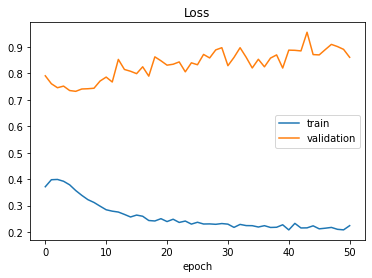

In [ ]:
# 손실 함수값 그래프 그리기
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train','validation'])
plt.title("Loss")
plt.xlabel("epoch")
plt.show()

#####3. L2 정규화

In [ ]:
# L2 정규화는 경계를 만들어 학습 데이터에서의 최적 변수 w*에 도달하지 못하게 함. 경계 안에서만 변수를 최적화 하게함.
# 따라서 모델 최적화된다면 v*로 수렴
# Adam 사용 시 weight_decay에 L2 패널티 값을 입력하고 L2 정규화 활성화, 패널티 값이 클수록 제약조건이 강해지고 0이면 정규화를 사용하지 않음 => 문제마다 적절한 값 입력 필수
optimizer = optim.Adam(resnet.parameters(), lr=1e-3, weight_decay=1e-3)

#####4. 드롭아웃

In [ ]:
# 인공 신경망에서 무작위로 일정한 비율의 노드를 제외, 학습하는 방법을 드롭아웃이라함.
# => 한 번 변수 갱신이 일어날 때마다 제외된 노드와 관련 있는 변수는 갱신 X => 학습 데이터에 대한 모델 최적화 억제 가능!
# 드롭아웃의 세팅 방법 : 출력층은 예측값이 나오는 단계이므로 적용 X => 출력층의 노드는 절대 지우지 않음, 원하는 층에만 적용 가능 & 제외 비율도 조정 가능
# 학습이 반복될 때마다 제외할 노드를 무작위로 선택, 학습에서 과적합 방지 & 시험 데이터를 이용하는 것과 같은 평가 단계에서는 드롭아웃 적용 X, 원래 전체 모델 사용(.eval()) 함수 선언
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13,50)
    self.fc2 = nn.Linear(50,1)
    self.dropout = nn.Dropout(0.5)

  def forward(self,x):
    x = self.dropout(F.relu(self.fc1(x)))
    x = F.relu(self.fc2(x))
    return x
# nn.Dropout(0.5)은 해당 노드에 50%를 선택해 노드를 사용하지 않겠다는 뜻, F.relu(self.fc1(x))의 노드는 50개이므로 25개 노드 비활성화.
# 또 다른 표현으로는 torch.nn.functional.dropout(input, p=0.5, training=True)

#####6. 교란 라벨

In [ ]:
# 교란 라벨은 분류 문제에서 일정 비율만큼 잘못된 라벨을 의도적으로 만들어 학습을 방해하는 방법.
# 단순하지만 분류 문제에서의 과적합을 효과적으로 막을 수 있다.
# 교란 라벨 정의
class DisturbLabel(torch.nn.Module): # DisturbLabel 클래스를 만든다.
  def __init__(self, alpha, num_classes): # 교란 라벨 비율(0~100)과 클래스 수를 받는다.
    super(DisturbLabel, self).__init__()
    self.alpha = alpha
    self.C = num_classes
    self.p_c = (1-((self.C - 1) / self.C) * (alpha/100)) # 실제 라벨을 뽑을 확률을 self.p_c로 부여, 나머지는 self.p_i로 부여
    self.p_i = (1-self.p_c)/(self.C-1) # ex. 클래스 수가 10, 교란 라벨 비율이 30%라면 self.p_c = 73/100, self.p_i=3/100, 실제 라벨이 5라면 뽑힐 확률 분포 = (3/100, 3/100, 3/100, 3/100, 3/100, 73/100, 3/100, 3/100, 3/100, 3/100)
  def forward(self,y):
    y_tensor = y.type(torch.LongTensor).view(-1,1) # 앞서 언급한 라벨이 뽑힐 확률 분포를 만들어줌.
    depth = self.C
    y_one_hot = torch.ones(y_tensor.size()[0], depth) * self.p_i
    y_one_hot.scatter_(1, y_tensor, self.p_c)
    y_one_hot = y_one_hot.view(*(tuple(y.shape) + (-1,))) # 해당 확률을 이용, Multinoulli 분포를 통해 샘플을 뽑음
    distribution = torch.distributions.OneHotCategorical(y_one_hot)
    y_disturbed = distribution.sample()
    y_disturbed = y_disturbed.max(dim=1)[1] # 10개의 원소 중 가장 큰 값의 라벨을 뽑음. 확률 분포를 이용해 교란 라벨을 만들기에, 비율이 30%라고 해서 반드시 미니 배치의 30%가 교란 라벨인 것은 아님.
    return y_disturbed

In [ ]:
# 교란 라벨 선언 및 적용
loss_ = []
n = len(trainloader)
disturblabels = DisturbLabel(alpha=30, num_classes=10) # 학습 전 DisturbLabel 선언
for epoch in range(50):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = resnet(inputs)
    labels = disturblabels(labels).to(device) # 손실 함수 계산 이전에 교란 라벨 생성, 거짓 라벨과 함께 손실 함수를 계산하게 함.
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  loss_.append(running_loss / n)
  print('[%d] loss: %.3f' %(epoch + 1, running_loss / n))

torch.save(resnet.state_dict(), PATH)
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1] loss: 2.031
[2] loss: 1.816
[3] loss: 1.736
[4] loss: 1.648
[5] loss: 1.613
[6] loss: 1.549
[7] loss: 1.509
[8] loss: 1.473
[9] loss: 1.442
[10] loss: 1.414
[11] loss: 1.394
[12] loss: 1.372
[13] loss: 1.340
[14] loss: 1.328
[15] loss: 1.313
[16] loss: 1.317
[17] loss: 1.286
[18] loss: 1.280
[19] loss: 1.284
[20] loss: 1.255
[21] loss: 1.274
[22] loss: 1.258
[23] loss: 1.254
[24] loss: 1.249
[25] loss: 1.238
[26] loss: 1.257
[27] loss: 1.247
[28] loss: 1.236
[29] loss: 1.245
[30] loss: 1.249
[31] loss: 1.243
[32] loss: 1.230
[33] loss: 1.242
[34] loss: 1.230
[35] loss: 1.233
[36] loss: 1.238
[37] loss: 1.230
[38] loss: 1.233
[39] loss: 1.212
[40] loss: 1.238
[41] loss: 1.246
[42] loss: 1.234
[43] loss: 1.225
[44] loss: 1.226
[45] loss: 1.210
[46] loss: 1.220
[47] loss: 1.237
[48] loss: 1.227
[49] loss: 1.217
[50] loss: 1.207
Finished Training


#####7. 교란 값

In [120]:
import pandas as pd # 데이터프레임 형태를 다룰 수 있는 라이브러리
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.

# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Loss
from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

# Plot
import matplotlib.pyplot as plt # 시각화 도구

In [125]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x)) 
      
        return x

In [126]:
model = Regressor()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [127]:
# 교란 값은 회귀 문제에서 일정 비율만큼 라벨에 노이즈 주입, 학습 데이터에 대해 최적화를 방해하는 방법
# 아주 간단, 어떠한 모델에도 적용 할 수 있다는 것이 큰 장점
# 노이즈 생성
def noise_generator(x, alpha): # 타깃값과 노이즈 비율(0~1을 받음)
    noise = torch.normal(0, 1e-2, size=(len(x), 1)) # 임의로 정한 정규분포에 따른 노이즈 생성
    noise[torch.randint(0, len(x), (int(len(x)*(1-alpha)),))] = 0 # 노이즈 타깃이 아닌 값은 노이즈를 0으로함.

    return noise

In [ ]:
loss_ = [] 
n = len(trainloader)

for epoch in range(400): 

    running_loss = 0.0

    for data in trainloader: 
        inputs, values = data 
       
        optimizer.zero_grad() 

        outputs = model(inputs) 
        values = values + noise_generator(values, 0.3)
        loss = criterion(outputs, values)
"""
이하 생략, 앞과 과정이 동일함.
"""

#####8. 라벨 스무딩

In [ ]:
# 파이토치에서 제공하는 크로스 엔트로피 함수 nn.CrossEntropyLoss()는 실제 라벨의 원 핫 벡터를 입력으로 못받음. => 라벨 스무딩 적용 시 원 핫 벡터를 사용할 수 있도록 별도로 손실 함수 생성해야함.
# 라벨 스무딩 정의 및 선언
class LabelSmoothingLoss(nn.Module):
  def __init__(self, classes, smoothing=0.0, dim = -1):
    super(LabelSmoothingLoss, self).__init__()
    self.confidence = 1.0 - smoothing
    self.smoothing = smoothing
    self.cls = classes
    self.dim = dim

  def forward(self, pred, target):
    pred = pred.log_softmax(dim=self.dim) # Cross Entropy 부분의 log softmax를 미리 계산 
    with torch.no_grad():
      true_dist = torch.zeros_like(pred) # 예측값과 동일한 크기의 영텐서 생성
      true_dist.fill(self.smoothing / (self.cls - 1)) # alpha(K-1) 생성 (alpha/K 가능)
      true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) # (1-alpha)y + alpha(K-1) 수행.
    return torch.mean(torch.sum(-true_dist * pred, dim=self.dim)) # pred를 함께 사용, Cross Entropy Loss 함수 계산
  

In [ ]:
criterion = LabelSmoothingLoss(classes=10, smoothing=0.2) # Cifar10 데이터 사용 시 클래스는 10개로 지정, 적절한 스무딩 비율을 넣어 nn.CrosEntropyLoss() 대신 LabelSmoothingLoss로 criterion 선언

####(2) 데이터 불균형

#####1. 가중 무작위 샘플링

In [ ]:
# 주어진 데이터가 불균형 데이터라도 우리는 미니 배치를 균형 데이터로 뽑을 수 있음.
# => 배치를 만들 때마다 각 클래스의 동일한 개수를 뽑는다면 한 번 학습 시 균형 데이터를 사용하게 됨.
# 이 방법을 가중 무작위 샘플링이라한다.
# 가중치 함수 만들기
import numpy as np
def make_weights(labels, nclasses): # 라벨과 클래스 수를 받음.
  labels = np.array(labels) # 리스트 타입을 넘파이 배열로 바꿈.
  weight_list=[]
  for cls in range(nclasses): # 각 클래스마다 라벨의 개수를 셈
    idx = np.where(labels == cls)[0]
    count = len(idx)
    weight = 1/count # 라벨이 뽑힐 가중치를 1/count로 동일하게 해당 라벨 전체에 할당
    weights = [weight] * count
    weight_list+=weights # 데이터를 불러올 때 ImageFolder를 사용할 경우 라벨이 0부터 N 까지 차례대로 나열되어 있음. => 각 클래스의 가중치를 일렬로 이어줌.
  return weight_list

In [ ]:
# 이미지 데이터 불러오기
# 이 예시에서는 클래스가 2개인 이미지 데이터를 불러온다.(각각 14, 4개)
transf = tr.Compose([tr.Resize((16,16)),tr.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/deeplearning/class', transform=transf)

In [ ]:
# 가중치 생성
weights = make_weights(trainset.targets, len(trainset.classes)) # 가중치를 생성 후 텐서로 변환
weights = torch.DoubleTensor(weights)
print(weights)
# 가중치 텐서를 보면 모든 데이터에 대한 각각의 가중치가 있음을 알 수 있음. & 각 클래스의 가중치의 합이 1로 같음
# => 하나의 클래스를 뽑을 확률이 같다는 의미(파이토치에서는 weights의 전체 합이 1일 필요 X)

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
        0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714],
       dtype=torch.float64)


In [ ]:
# 데이터로더 생성
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) # 파이토치에서 제공하는 WeightedRandomSampler를 사용, 배치를 불러올 때 자동으로 클래스에 대한 균일 분포를 갖는 배치를 만들 수 있다.
trainloader_wrs = DataLoader(trainset, batch_size=6, sampler=sampler) # DataLoader에 sampler를 추가, 데이터 준비를 완료함.
trainloader_rs = DataLoader(trainset, batch_size=6, shuffle=True) # 가중 무작위 샘플링과 무작위 샘플링의 비교를 위해 무작위 샘플링을 하는 DataLoader를 추가적으로 만듦.

In [ ]:
# 가중 무작위 샘플링vs무작위 샘플링
# 배치 사이즈를 6개로 한 경우 2개의 클래스가 각각 3개로 들어오는 것이 이상적, But, 확률적으로 데이터를 뽑기 때문에 반드시 3개씩 뽑히지 않음 => 그래도 무작위 샘플링 보다는 균형 잡힌 데이터
for epoch in range(5):
  for data in trainloader_wrs:
    print(data[1])
# 현재 데이터는 클래스 1이 클래스 0보다 3.5배 많음

tensor([0, 0, 1, 1, 1, 1])
tensor([0, 1, 1, 0, 1, 0])
tensor([0, 1, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 0, 0])
tensor([1, 0, 0, 1, 0, 0])
tensor([1, 1, 0, 0, 0, 0])
tensor([0, 0, 1, 1, 1, 0])
tensor([1, 0, 0, 0, 1, 1])
tensor([1, 1, 1, 0, 1, 0])
tensor([1, 1, 1, 1, 0, 0])
tensor([0, 0, 0, 0, 1, 0])
tensor([0, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 1])
tensor([1, 0, 1, 1, 1, 1])


In [ ]:
# 다음과 같이 무작위로 뽑았을 경우 클래스 1이 배치 전체를 차지함을 알 수 있음.
for epoch in range(5):
  for data in trainloader_rs:
    print(data[1])

tensor([1, 1, 1, 0, 1, 1])
tensor([0, 1, 1, 0, 1, 1])
tensor([1, 1, 0, 1, 1, 1])
tensor([0, 0, 1, 0, 1, 1])
tensor([0, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 0, 1, 1])
tensor([1, 1, 1, 0, 1, 1])
tensor([0, 1, 1, 1, 1, 1])
tensor([1, 1, 0, 1, 0, 1])
tensor([1, 1, 1, 1, 0, 1])
tensor([1, 1, 1, 1, 0, 1])
tensor([1, 1, 1, 0, 1, 0])


#####2. 가중 손실 함수

In [ ]:
# 파이토치의 nn.CrossEntropyLoss는 가중 손실 함수 제공 => 미리 정의된 weight를 입력하면 쉽게 구현 가능.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_ins = [40, 45, 30, 62, 70, 153, 395, 46, 75, 194] # ex. 10개 클래스의 각각 이미지 개수를 알고 있다고 가정. 가중 손실 함수는 데이터가 적은 클래스에 큰 가중치를 부여, 업데이트 균형을 맞추려는 의도를 지님.
weights = [1-(x/sum(num_ins)) for x in num_ins] # 이 예시에서는 각 클래스의 확률 x/sum(num_ins)를 구한 뒤 1에서 뺀 값을 가중치로 사용
class_weights = torch.FloatTensor(weights).to(device) # 다음 텐서로 변환된 가중치를 nn.CrossEntropyLoss에 넣어줌.
criterion = nn.CrossEntropyLoss(weight=class_weights)

#####3. 혼동 행렬

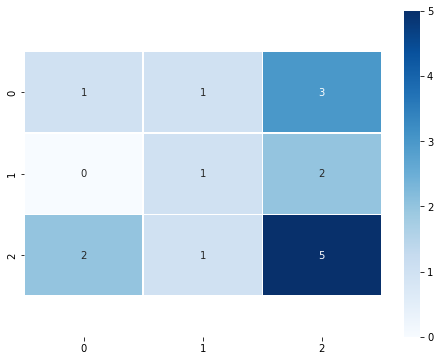

In [ ]:
# 혼동 행렬 : 데이터 불균형의 직접적인 해결책 X, But 결과를 행렬화하여 각 클래스의 분포, 정확도를 확인하여 불균형 데이터로 예측 쏠림 현상 인지 가능. 다양한 결과와 해석에 사용
from sklearn.metrics import confusion_matrix # 관련 라이브러리 불러옴.
import seaborn as sns
from matplotlib import pyplot as plt
actual = [1,1,1,0,0,0,0,0,2,2,2,2,2,2,2,2] # 실제값과 예측값을 알고 있다고 가정
prediction = [1,2,2,0,2,2,1,2,0,1,0,2,2,2,2,2]
c_mat = confusion_matrix(actual, prediction) # 혼동 행렬 틀을 만들어 플로팅
plt.figure(figsize = (8,6))
sns.heatmap(c_mat, annot=True, fmt="d", cmap='Blues', linewidths=.5)
b, t = plt.ylim() # 이때 그냥 plt.ylim()을 사용할 경우 버전에 따라 위, 아래가 잘려서 그래프가 출력 될 수 있으므로 위, 아래 범위를 0.5씩 확보
b+=0.5
t-=0.5
plt.ylim(b,t)
plt.savefig('confusion_matrix.png')
plt.show()
# 결과 확인 => 클래스 0, 1이 클래스2로 많이 예측된걸 확인 가능, 즉 모델 변수가 데이터가 가장 많은 클래스2로 치우쳐 있다는 뜻.

####(3) 전이 학습

#####1. 사전 학습 모델

In [ ]:
# 앞에서 봤듯이 torchvision.models as models를 이용, ImageNet 데이터로 학습된 사전 학습 모델을 쉽게 사용 가능.
# 또 앞에서 봤듯이 모델 내부의 변수명 확인 & 모델 일부 수정 가능
import torchvision.models as models
alexnet = models.alexnet().to(device)
resnet18 = models.resnet18().to(device)
vgg16 = models.vgg16().to(device)
densenet = models.densenet161().to(device)
inception = models.inception_v3().to(device)
googlenet = models.googlenet().to(device)
shufflenet = models.shufflenet_v2_x1_0().to(device)
mobilenet_v2 = models.mobilenet_v2().to(device)
resnext50_32x4d = models.resnext50_32x4d().to(device)
wide_resnet50_2 = models.wide_resnet50_2().to(device)
mnasnet = models.mnasnet1_0().to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:47: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:51: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [ ]:
# CIFAR10을 위한 ResNet18 불러오기
model = torchvision.models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1) # 불러온 모델: 사이즈가 CIFAR10보다 큰, ImageNet 데이터가 맞춰진 모델 => 원래 첫번째 합성곱 층의 필터 사이즈가 7X7이라서 CIFAR10 데이터에는 큰 사이즈임. => 3X3 vlfxjfh qusrud
num_ftrs = model.fc.in_features # 원래 모델의 마지막 출력 노드가 1000이기 때문에 우리 데이터에 맞춰 10개로 변경
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#####2. 모델 프리징

In [ ]:
# 모델 프리징 : 기존의 일부 모델 변수들을 그대로 사용하기 위해 업데이트가 되지 않도록 하는 방법
# => 사전 학습된 변수를 그대로 유지 가능, 학습 속도와 정확도 향상, 다른 모델과 붙여 다른 구조를 만들 수 있다.
# CNN에서는 피쳐 추출 부분은 프리징 시키고 분류 파트만 학습을 진행하기도 함. But, 모델을 튜닝하고 프리징하는데 정답 따윈 없으니 다양한 시도 하자.
# 모델 불러오기
model = torchvision.models.alexnet(pretrained=True) # 모델을 불러온 후 출력 레이어의 노드 = 클래스 수로 설정
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs,10)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 모델 파라미터명 확인
for i, (name, param) in enumerate(model.named_parameters()): # model.named_parameters()를 이용, 가중치와 편향 목록 출력 가능.
  print(i, name) # 리스트의 차례를 알 수 있도록 i와 같이 출력. 출력 결과를 보면 0~9번째는 합성곱 층에 대한 가중치 & 편향, 10번 이후는 분류기의 가중치와 편향.

0 features.0.weight
1 features.0.bias
2 features.3.weight
3 features.3.bias
4 features.6.weight
5 features.6.bias
6 features.8.weight
7 features.8.bias
8 features.10.weight
9 features.10.bias
10 classifier.1.weight
11 classifier.1.bias
12 classifier.4.weight
13 classifier.4.bias
14 classifier.6.weight
15 classifier.6.bias


In [ ]:
# 변수 프리징
for i, (name, param) in enumerate(model.named_parameters()):
  param.requires_grad = False # 파라미터의 requires_grad를 False로 하여 학습 시 업데이트 되지 않도록 함.
  if i ==9: # if문을 통해 합성곱 층에 대한 가중치와 편향(9번까지)만 프리징이 되면 for문을 멈춤.
    print('end')
    break

end


In [ ]:
f_list = [0,3,6,8,10]
c_list = [1,4,6]
for i in f_list:
  print(model.features[i].weight.requires_grad)
  print(model.features[i].bias.requires_grad)
for j in c_list:
  print(model.classifier[j].weight.requires_grad)
  print(model.classifier[j].bias.requires_grad)

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


####(4) 준지도 학습

#####1. 의사 라벨링

In [ ]:
# 의사 라벨링 : 준지도 학습 중 가장 기본적으로 사용되는 방법.
# 우리가 라벨이 없는 데이터를 지도 학습에 사용시에는 라벨을 달아 줘야함. => 이미 학습된 모델을 이용하여 라벨링이 되지 않는 데이터를 예측, 그 예측값을 기준으로 라벨링 하여 기존의 학습 데이터와 함께 학습에 사용하는 방법이 의사 라벨링.
# 주의점: 예측값을 라벨로 이용, 라벨에 대한 불확실성 존재 => 무분별한 사용 자제 & 다양한 형태로 모델 구현 가능. 우리는 2가지 의사 라벨링 방법을 정의하여 성능 향상 달성할 것임.
# 라이브러리 불러오기
import torch # 넘파이 및 파이토치 라이브러리 불러오기
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm # for문의 진행 상황을 알려주는 라이브러리

In [ ]:
# GPU 연산 정의
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# 데이터 세트 정의
class MyDataset(Dataset): # 이전의 내용을 바탕으로 데이터 세트 클래스 정의
  def __init__(self, x_data, y_data, transform=None):
    self.x_data = x_data
    self.y_data = y_data
    self.transform = transform
    self.len = len(y_data)

  def __getitem__(self, index):
    sample = self.x_data[index], self.y_data[index]
    if self.transform:
      sample = self.transform(sample)
    return sample

  def __len__(self):
    return self.len

In [ ]:
# 데이터 전처리 정의
class TrainTransform: # 마찬가지로 이전의 내용을 바탕으로 학습 데이터 대한 전처리 정의
  def __call__(self, sample):
    inputs, labels = sample
    transf = transforms.Compose([transforms.ToPILImage(),
                                 transforms.RandomHorizontalFlip(), transforms.ToTensor()])
    final_output = transf(inputs)
    return final_output, labels

In [ ]:
# 데이터 세트 나누기
# 실험을 위해 각 클래스의 이미지 개수가 같도로 데이터를 나눈다.
def balanced_subset(data, labels, num_cls, num_data): # 데이터, 라벨, 클래스 수, 나눠지는 목표 데이터 개수를 받음.
  num_data_per_class = num_data // num_cls # 각 클래스의 데이터 개수 정의
  data1 = torch.tensor([], dtype=torch.float) # 나눠지는 두 개의 세트를 저장하기 위해 데이터, 라벨 텐서를 각각 2개 정의
  data2 = torch.tensor([], dtype=torch.float)
  labels1 = torch.tensor([], dtype=torch.long)
  labels2 = torch.tensor([], dtype=torch.long)
  for cls in range(num_cls): # 각 클래스마다 정의된 데이터 개수 만큼 무작위로 뽑아 저장
    idx = np.where(labels.numpy() == cls)[0] # 이때 np.where를 사용하기 위해 labels 텐서를 넘파이 배열로 바꿔 사용
    shuffled_idx = np.random.choice(len(idx), len(idx), replace=True)
    data1 = torch.cat([data1, data[shuffled_idx[:num_data_per_class]]], dim=0)
    data2 = torch.cat([data2, data[shuffled_idx[num_data_per_class:]]], dim=0)
    labels1 = torch.cat([labels1, labels[shuffled_idx[:num_data_per_class]]], dim=0)
    labels2 = torch.cat([labels2, labels[shuffled_idx[:num_data_per_class]]], dim=0)
  return data1, data2, labels1, labels2

In [ ]:
# 데이터 불러오기
trainset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/deeplearning/data', train=True, download=True) # 숫자 판별 MNIST 데이터를 불러옴.
labeled_data, unlabeled_data, labels, unlabels = balanced_subset(trainset.data, # 이번 실험에서는 라벨링된 데이터가 2000개만 있다고 가정, 학습 데이터, 검증 데이터를 각각 1000개씩 사용, 나머지는 라벨링이 안된 데이터라고 가정.
                                                                 trainset.targets, num_cls=10, num_data=2000)
train_images, val_images, train_labels, val_labels = balanced_subset(labeled_data, labels,
                                                                     num_cls=10, num_data=1000)

In [ ]:
# 데이터로더 정의
train_images = train_images.unsqueeze(1) # CNN은 4차원 입력 이미지 필요. But, 1채널인 MNIST 데이터는 (배치사이즈, 이미지 너비, 이미지 높이) 형태인 3차원
# => unsqueeze(1)을 통해 3차원 텐서를 4차원 텐서 (배치사이즈, 1, 이미지 너비, 이미지 높이)로 변환.
val_images = val_images.unsqueeze(1)
trainset = MyDataset(train_images, train_labels, transform=TrainTransform()) # 학습 데이터에는 TrainTransform()을 적용
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle = True)
validationset = MyDataset(val_images, val_labels) # 나머지 세트에 대해서는 적용 X.
valloader = torch.utils.data.DataLoader(validationset, batch_size=128, shuffle=False)
unlabeled_images = unlabeled_data.unsqueeze(1)
unlabeledset = MyDataset(unlabeled_images, unlabels)
unlabeledloader = torch.utils.data.DataLoader(unlabeledset, batch_size=256, shuffle=True)
transform = transforms.Compose([transforms.ToTensor()]) # 평가 데이터를 불러옴
testset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/deeplearning/data', train=False, download=True,
                                     transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [ ]:
# 모델 정의
class Net(nn.Module): # 임의의 모델 정의
  def __init__(self):
    super(Net, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1, 64, 3), nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),
        nn.MaxPool2d(2,2))
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(192*6*6, 1024), nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 512), nn.ReLU(),
        nn.Linear(512,10))
  def forward(self,x):
    x = self.features(x)
    x = x.view(-1, 192*6*6)
    x = self.classifier(x)
    return x

model = Net().to(device)

In [ ]:
# 손실 함수 및 최적화 기법 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 정확도 평가 함수 정의
def accuracy(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for data in dataloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total+=labels.size(0)
      correct+=(predicted==labels).sum().item()
  acc = 100*correct/total
  model.train()
  return acc

In [ ]:
# 지도 학습 수행
# 기준 성능을 알아보기 위해 1000개의 라벨링된 데이터로만 학습 진행
best_acc = 0 # 검증 정확도를 기준으로 모델을 저장하기 위해 변수 선언
for epoch in range(501): # 학습 데이터를 이용해 학습하고, 학습 정확도 계산
  correct = 0
  total = 0
  for traindata in trainloader:
    inputs, labels = traindata[0].to(device), traindata[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.detach(), 1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()
  val_acc = accuracy(valloader) # 검증 정확도를 계산, 가장 높은 검증 정확도를 기준으로 모델 파라미터를 정함.
  if val_acc>=best_acc:
    best_acc=val_acc
    torch.save(model.state_dict(), '/content/drive/MyDrive/deeplearning/models/cifar_model_for_pseudo_baseline.pth')
    print('[%d] train acc: %.2f, validation acc:%.2f - Saved the best model' %(epoch, 100*correct/total, val_acc))
  elif epoch%10==0: # 학습 상황을 알 수 있도록 에포크 1-마다 학습 정확도와 검증 정확도 출력
    print('[%d] train acc: %.2f, validation acc: %.2f' %(epoch, 100*correct/total, val_acc))

[0] train acc: 16.80, validation acc:11.10 - Saved the best model
[10] train acc: 94.70, validation acc: 10.40
[20] train acc: 99.30, validation acc: 10.40
[26] train acc: 99.70, validation acc:11.70 - Saved the best model
[30] train acc: 99.90, validation acc: 10.70
[40] train acc: 99.90, validation acc: 10.90
[50] train acc: 99.70, validation acc: 10.80
[60] train acc: 100.00, validation acc: 11.60
[70] train acc: 99.60, validation acc: 10.20
[80] train acc: 99.90, validation acc:11.70 - Saved the best model
[81] train acc: 99.60, validation acc:11.80 - Saved the best model
[90] train acc: 99.80, validation acc: 11.10
[100] train acc: 99.70, validation acc: 11.10
[110] train acc: 99.60, validation acc: 10.60
[120] train acc: 99.90, validation acc: 10.90
[130] train acc: 99.90, validation acc: 11.10
[140] train acc: 99.50, validation acc: 10.70
[150] train acc: 99.80, validation acc: 10.50
[154] train acc: 99.60, validation acc:11.80 - Saved the best model
[160] train acc: 99.50, vali

In [ ]:
# 지도 학습 성능 평가
model.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/cifar_model_for_pseudo_baseline.pth'))
accuracy(testloader) # 저장된 베스트 모델을 가지고 와서, 평가 정확도를 측정함. 이때 지도 학습의 정확도는 67.79%

67.79

In [ ]:
# 준지도 학습1을 위한 모델 재정의
model = Net().to(device) # 모델 파라미터 초기화, 준지도 학습 진행
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:
# 준지도 학습 1 수행
# 의사 라벨링 : 정확한 라벨 & 부정확한 라벨 섞여있음 => 훈련 데이터와 동일하게 모델 최적화에 사용시 오히려 안좋아 => 훈련 라벨과 의사 라벨을 구분 & 따로 손실 함수(L_t와 L_p)를 계산한 뒤 둘을 더해 전체 손실 함수 L(L=L_t+alpha*L_p)을 정의.
# 의사 라벨을 이용하는 손실 함수 부분에 가중치 alpha를 주어 학습 개입을 조절 가능. => alpha=0이면 학습 데이터로만 모델을 최적화 한다는 뜻, alpha가 커질수록 의사 라벨의 영향도가 커짐.
# => 연구마다 영향도의 차이가 다를 수 있으니 적절한 alpha를 정의하는 것이 중요.
alpha = 0
alpha_t = 1e-4
T1 = 100 # 이 예시에서는 처음 에포크 100번까지는 alpha=0으로 학습을 진행
T2 = 450 # 이후 에포크가 450이 될때까지 일정하게 alpha를 높여 학습을 시행, 450회가 지나면 alpha를 alpha_t로 고정하여 학습을 진행하여 마무리 => alpha를 0부터 1e-4까지 점차 높여 학습 진행
best_acc = 0
for epoch in range(501):
  correct = 0
  total = 0
  for traindata, pseudodata in zip(trainloader, unlabeledloader): # zip을 이용, 두 개의 데이터로더 동시에 이용 가능
    inputs, labels = traindata[0].to(device), traindata[1].to(device)
    pinputs = pseudodata[0].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    if alpha > 0 : # 0보다 크면 의사 라벨로 함께 이용하여 손실 함수 계산
      poutputs = model(pinputs)
      _, plabels = torch.max(poutputs.detach(), 1)
      loss = criterion(outputs, labels) + alpha*criterion(poutputs, plabels)
    else: # alpha=0이면 학습 데이터만 이용하며 손실함수를 계산
      loss = criterion(outputs, labels) # 첫 번째 의사 라벨 방법에서는 모델의 출력 벡터와 출력 벡터로 만든 예측 라벨과의 손실 함수를 계산하는 것!
      # ex. (0.1, 0.6, 0.3)이라는 출력 벡터가 나왔다면 예측 라벨은 (0,1,0)이 되고 이 둘을 손실 함수에 넣어 계산하게 됨.
    loss.backward()
    optimizer.step() # 다음, 조건에 맞는 손실 함수를 기준으로 모델을 최적화
    _, predicted = torch.max(outputs.detach(), 1) # 학습 정확도 계산을 위해 정답 개수, 총 라벨 개수 누적
    total+=labels.size(0)
    correct+=(predicted == labels).sum().item()
    if (epoch>T1) and (epoch<T2): # 학습이 1회가 완료되면 epoch 확인하여 alpha 업데이트
      alpha = alpha_t*(epoch - T1)/(T2-T1)
    elif epoch>=T2:
      alpha = alpha_t
    val_acc = accuracy(valloader) # 검증 정확도를 계산, 가장 높은 검증 정확도를 기준으로 모델 파라미터 저장
    if val_acc>=best_acc:
      best_acc = val_acc
      torch.save(model.state_dict(), '/content/drive/MyDrive/deeplearning/models/cifar_model_for_pseudo_label.pth')
      print('[%d]train acc:%.2f, validation acc:%.2f -Saved the best model'%(epoch, 100*correct/total, val_acc))
    elif epoch%10==0: # 학습 상황을 알 수 있도록 epoch 10마다 학습 정확도와 검증 정확도 출력
      print('[%d]train acc:%.2f, validation acc:%.2f'%(epoch, 100*correct/total, val_acc))

[0]train acc:100.00, validation acc:11.70 -Saved the best model
[0]train acc:100.00, validation acc:11.80 -Saved the best model
[0]train acc:100.00, validation acc:11.80 -Saved the best model
[0]train acc:100.00, validation acc:11.80 -Saved the best model
[0]train acc:100.00, validation acc:11.80 -Saved the best model
[0]train acc:100.00, validation acc:11.80 -Saved the best model
[0]train acc:100.00, validation acc:11.80 -Saved the best model
[0]train acc:100.00, validation acc:11.80 -Saved the best model
[1]train acc:100.00, validation acc:11.80 -Saved the best model
[1]train acc:100.00, validation acc:11.80 -Saved the best model
[1]train acc:100.00, validation acc:11.90 -Saved the best model
[1]train acc:100.00, validation acc:11.90 -Saved the best model
[2]train acc:99.87, validation acc:11.90 -Saved the best model
[2]train acc:99.89, validation acc:12.00 -Saved the best model
[10]train acc:100.00, validation acc:11.30
[10]train acc:100.00, validation acc:11.30
[10]train acc:100.00

In [ ]:
# 준지도 학습1 성능 평가
# 평가 정확도가 기준 대비 2.54% 증가 한 %이다.(기준 73.8%)
model.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/cifar_model_for_pseudo_label.pth'))
accuracy(testloader)

76.34

In [ ]:
# 준지도 학습2를 위한 모델 재정의
model = Net().to(device) # 손실함수와 최적화 방법 정의
model.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/cifar_model_for_pseudo_baseline.pth'))
# 이번 방법에서는 학습 데이터로 학습된 사전 훈련 모델을 가지고 의사 라벨을 생성 & 이를 실제 라벨 처럼 사용
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 의사 라벨 생성
pseudo_threshold = 0.99
pseudo_images = torch.tensor([], dtype=torch.float)
pseudo_labels = torch.tensor([], dtype=torch.long)
with torch.no_grad():
  for data in tqdm(unlabeledloader):
    model.eval()
    images = data[0].to(device)
    outputs = model(images)
    outputs = torch.nn.functional.softmax(outputs, dim=1)
    max_val, predicted = torch.max(outputs.detach(), 1)
    idx = np.where(max_val.cpu().numpy()>=pseudo_threshold)[0]
    if len(idx)>0:
      pseudo_images = torch.cat((pseudo_images, images.cpu()[idx]),0)
      pseudo_labels = torch.cat((pseudo_labels, predicted.cpu()[idx]),0)

100%|██████████| 8/8 [00:00<00:00, 69.05it/s]


In [ ]:
# 준지도 학습2를 위한 데이터로더 정의
pseudo_dataset = MyDataset(pseudo_images, pseudo_labels)
pseudoloader = torch.utils.data.DataLoader(pseudo_dataset, batch_size=256, shuffle=True)

In [ ]:
# 준지도 학습2 수행
alpha = 0
alpha_t = 1e-4 # 의사 라벨링 개입에 대한 alpha 정의
T1 = 20
T2 = 450
best_acc = 0

In [ ]:
for epoch in range(501):
  correct = 0
  total = 0
  for traindata, pseudodata in zip(trainloader, pseudoloader): # zip을 이용, 두 개의 데이터로더 동시에 이용 가능
    inputs, labels = traindata[0].to(device), traindata[1].to(device) # 학습 데이터를 불러옴.
    pinputs, plabels = pseudodata[0].to(device), pseudodata[1].to(device) # 의사 라벨 데이터를 불러옴.
    optimizer.zero_grad()
    outputs = model(inputs) # 모델을 통해 예측값을 산출, 손실 함수 계산
    poutputs = model(pinputs)
    loss = criterion(outputs, labels) + alpha*criterion(poutputs, plabels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.detach(), 1) # 학습 정확도 계산을 위해 정답 개수와 총 라벨 개수 누적.
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()
    if(epoch>T1) and (epoch<T2): # 학습이 1회 완료되면 epoch를 확인, alpha를 업데이트
      alpha = alpha_t*(epoch - T1)/(T2-T1)
    elif epoch>=T2:
      alpha = alpha_t
    val_acc=accuracy(valloader) # 검증 정확도를 계산, 가장 높은 검증 정확도를 기준으로 모델 파라미터 저장
    if val_acc>=best_acc:
      best_acc = val_acc
      torch.save(model.state_dict(), '/content/drive/MyDrive/deeplearning/models/cifar_model_for_pseudo_label2.pth')
      print('[%d] train acc:%.2f, validation acc:%.2f'%(epoch, 100*correct/total, val_acc))
    elif epoch%10==0: # 학습 상황을 알 수 있도록 epoch 10마다 학습 정확도, 검증 정확도 출력.
      print('[%d] train acc:%.2f, validation acc:%.2f'%(epoch, 100*correct/total, val_acc))

[0] train acc:100.00, validation acc:10.40
[0] train acc:100.00, validation acc:10.30
[0] train acc:100.00, validation acc:10.80
[0] train acc:100.00, validation acc:10.80
[0] train acc:100.00, validation acc:11.40
[0] train acc:100.00, validation acc:11.30
[0] train acc:100.00, validation acc:10.90
[0] train acc:100.00, validation acc:11.00
[1] train acc:99.74, validation acc:11.70
[1] train acc:99.84, validation acc:11.80
[1] train acc:99.87, validation acc:11.90
[2] train acc:99.80, validation acc:11.90
[3] train acc:100.00, validation acc:12.00
[3] train acc:100.00, validation acc:12.10
[3] train acc:99.69, validation acc:12.10
[3] train acc:99.74, validation acc:12.10
[4] train acc:99.61, validation acc:12.20
[4] train acc:99.61, validation acc:12.20
[5] train acc:99.22, validation acc:12.30
[5] train acc:99.48, validation acc:12.30
[5] train acc:99.61, validation acc:12.30
[5] train acc:99.69, validation acc:12.30
[6] train acc:99.61, validation acc:12.50
[6] train acc:99.87, val

In [ ]:
# 준지도 학습2 성능 평가
# 평가 정확도가 기준 대비 0% 증가한 73.8%이다.(기준 73.8%)
model.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/cifar_model_for_pseudo_label2.pth'))
accuracy(testloader)

73.8